In [1]:
import sys
sys.path.append("../")
import argparse
import os
import json
from datasets import get_data_loader
from models import generate_network
import utils.engine

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# static vars
CFG_FILES = {
    "r2plus1d": "../manifest/FineTunedConvNet_MulticamFD@r2plus1d_18_cv.cfg",
    "guidenet": "../manifest/DefaultAGNet_MulticamFD@r2plus1d_18_cv.cfg"
}

FOLD = 3 # to be iterated
method = "guidenet" # to be iterated

class Opt():
    def __init__(self):
        pass

opt = Opt()

with open(CFG_FILES[method], 'r') as f:
    opt.__dict__ = json.load(f)

In [4]:
# Load data
train_loader, test_loader, target_transform, n_outputs = get_data_loader(opt, fold=FOLD)

train : 1141, test : 163



In [6]:
clips.shape

torch.Size([10, 3, 15, 112, 112])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


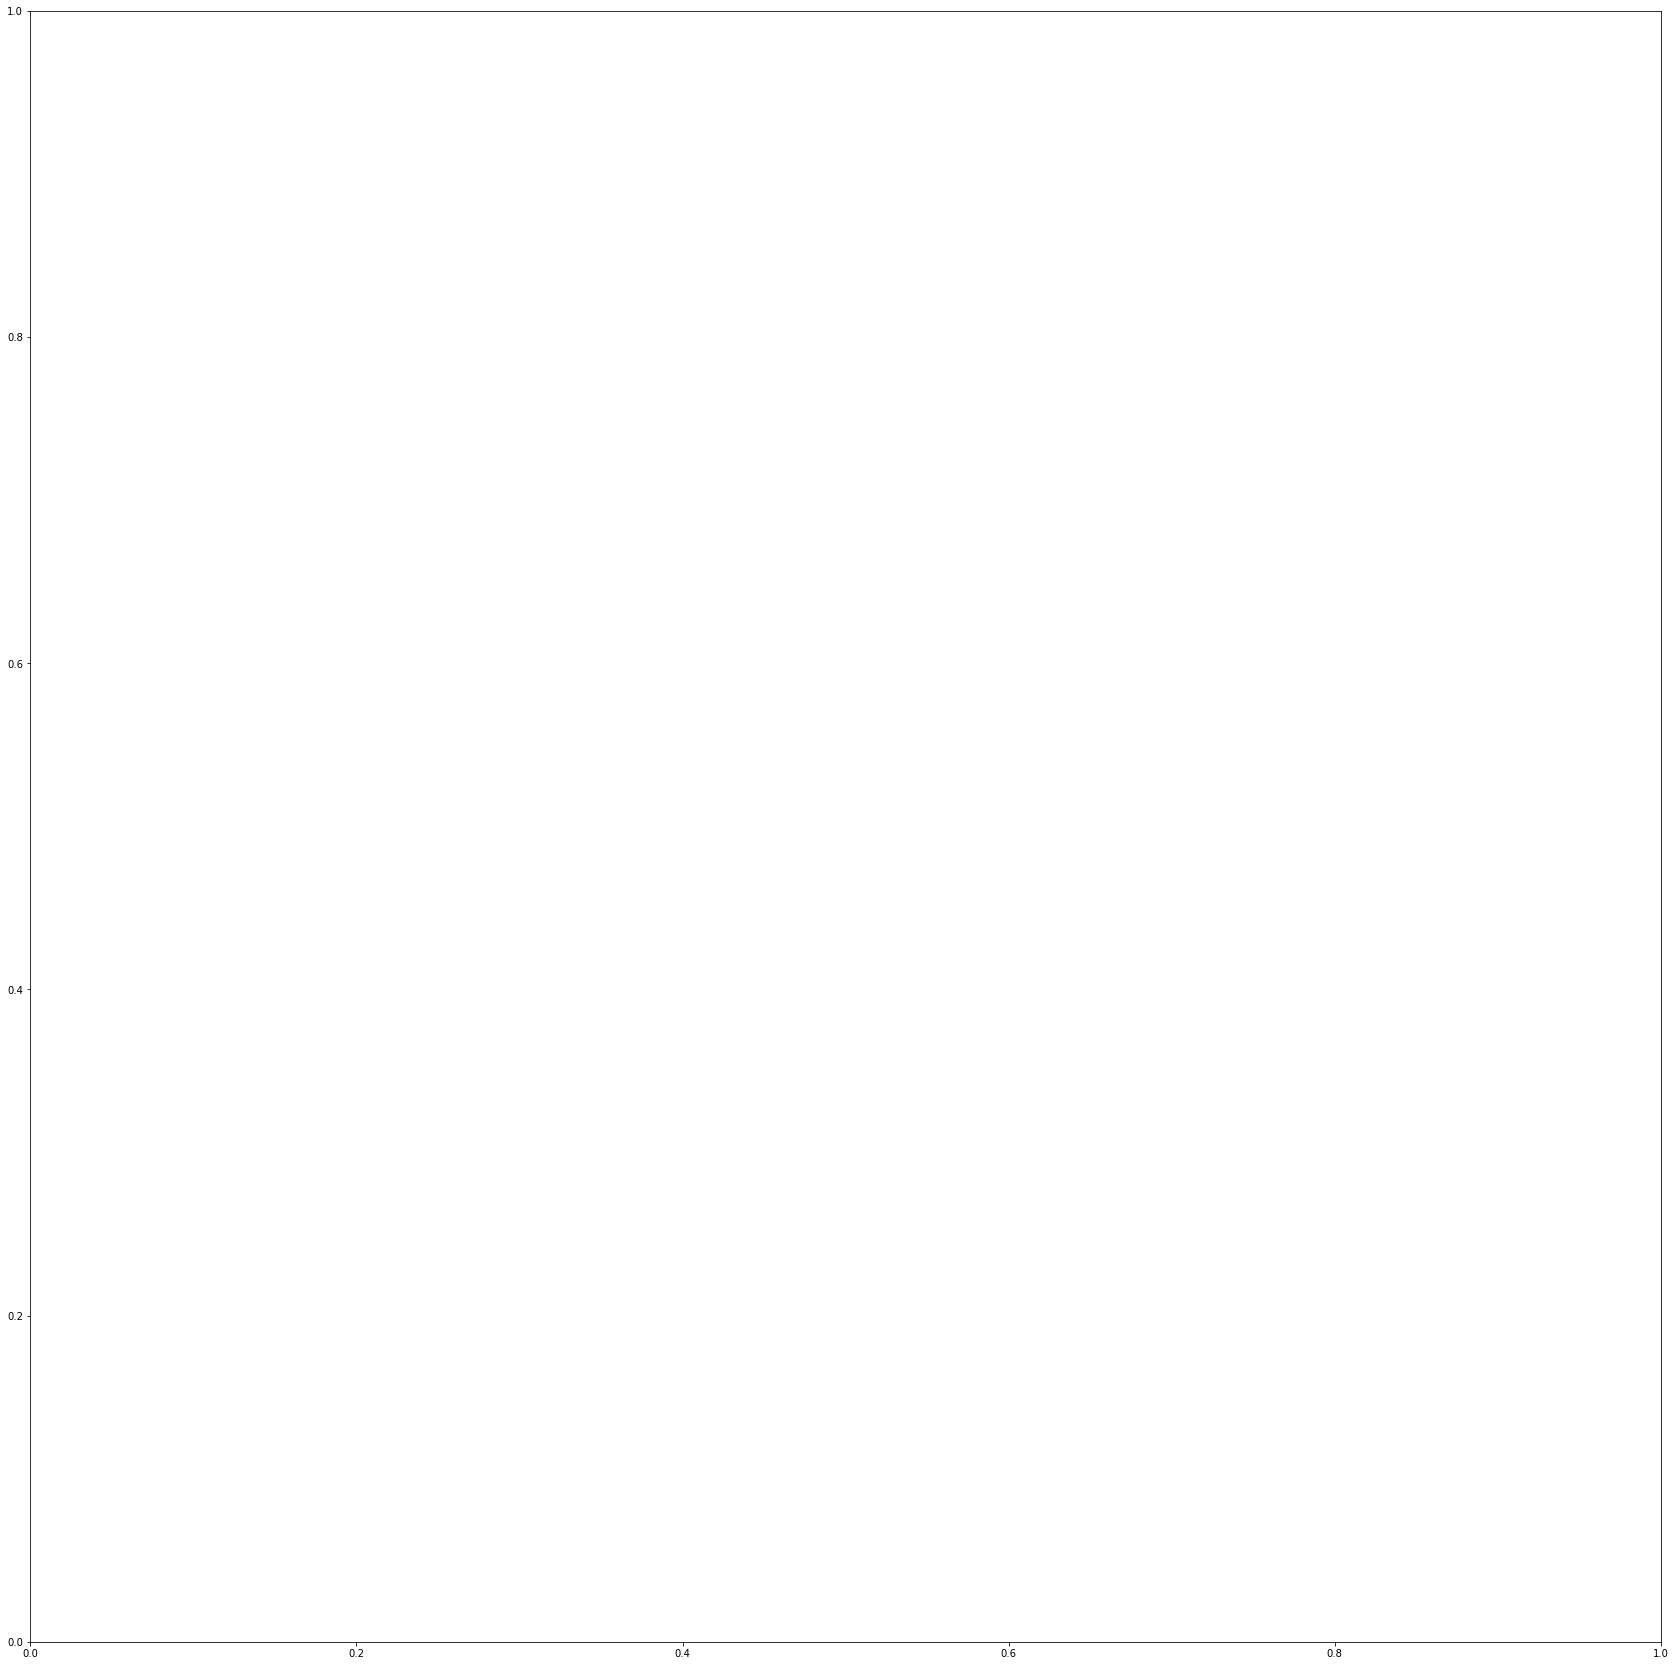

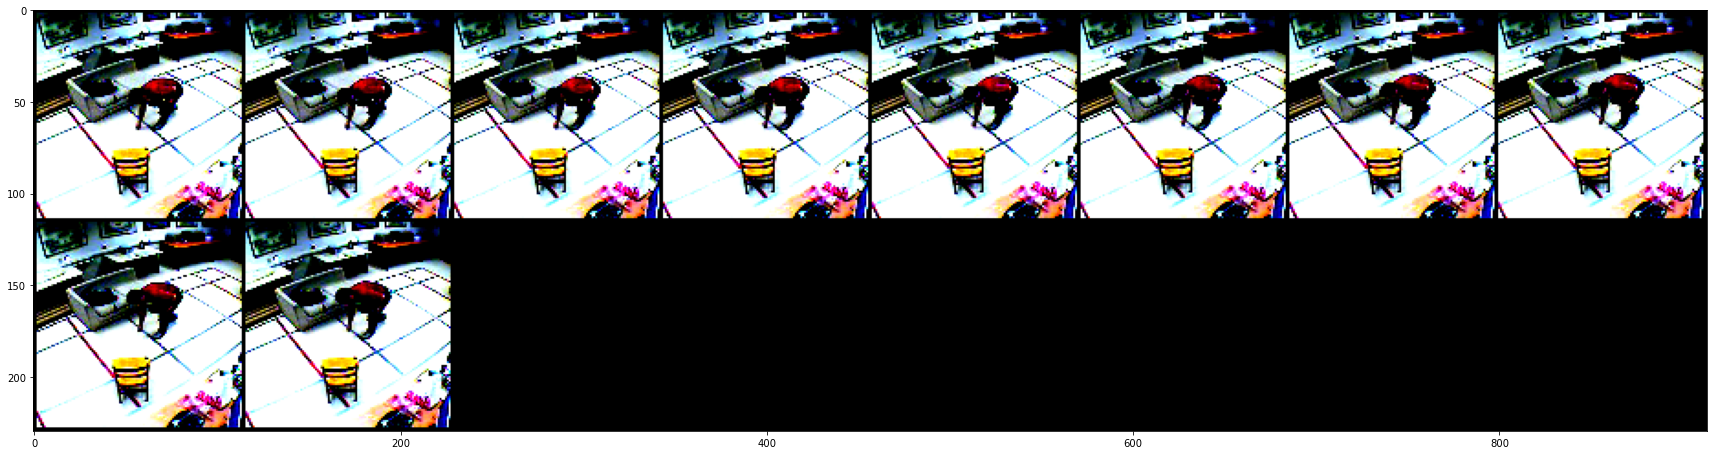

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


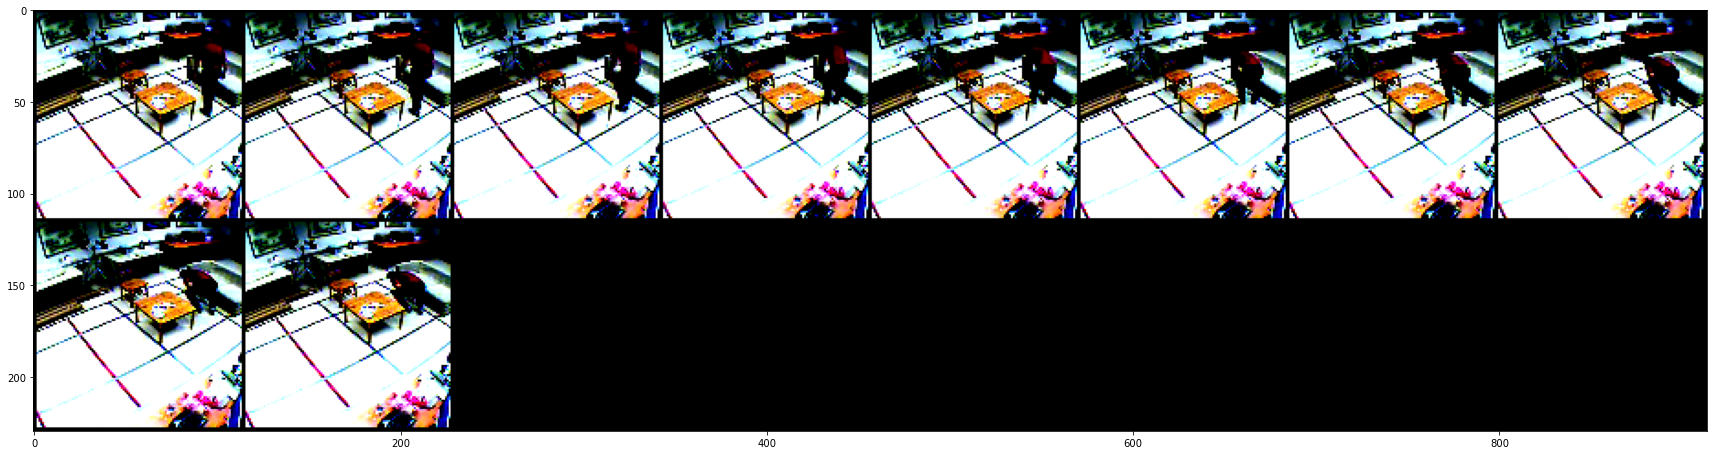

In [7]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

test_loader_iter = iter(test_loader)

for _ in range(2):
    clips, *_ = next(test_loader_iter)
    grid_arr = make_grid(clips[:, :, 0]).permute(1,2,0)

    plt.figure(figsize=(30,30))
    plt.imshow(grid_arr)
    plt.show()


In [ ]:
clips.shape

In [ ]:
# init net
model = generate_network(opt, n_outputs=n_outputs)
model

In [ ]:
net = utils.engine.VideoClassifier(model, optimizer=None,
                                   n_folds=opt.n_folds,
                                   fold=FOLD,
                                   lr_scheduler=None,
                                   warmup_scheduler=None)

In [ ]:
results = net.test(test_loader, 
         pretrained_path=f"/data/GaitData/ckpt_dir/FineTunedConvNet_MulticamFD@r2plus1d_18_cv/model_fold-{FOLD}.pth")
# todo. save results in .pkl
pass




In [160]:
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

def draw_roc(results, legend="foo", point_color=None, ax=None, title=None):
    if ax is None:
        ax = plt.gca()
    y = np.vstack(results["clip_trues"])
    scores = np.vstack(results["clip_probs"])[:, 1]

    fpr, tpr, thresholds = metrics.roc_curve(y, scores, pos_label=1)

    roc_auc = metrics.auc(fpr, tpr)
    
    lw = 2
    ax.plot(1-fpr, tpr, "-", color=point_color,
             lw=lw, label=f'{legend} (area = {roc_auc:.4f})')
    ax.plot([1, 0], [0, 1], color='gray', lw=lw, linestyle='--')
    ax.set_xlim([1.05, -0.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('Specificity')
    ax.set_ylabel('Sensitivity')
    if title is not None:
        ax.set_title(title)
    ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
    return tpr, 1-fpr

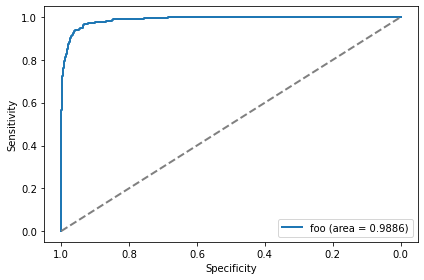

In [167]:
import pickle
results = pickle.load(open(f"/data/GaitData/ckpt_dir/DefaultAGNet_MulticamFD@r2plus1d_18_cv/prediction_fold-3.pkl", "rb"))
sensitivity, specificity = draw_roc(results)

In [168]:
probe_sensitivity = 0.98
hit_point = np.abs(sensitivity-probe_sensitivity).argmin()
print(f"sens:{sensitivity[hit_point]:.4f}, \nspec:{specificity[hit_point]:.4f}")

sens:0.9805, 
spec:0.8669


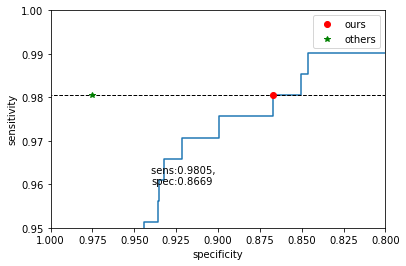

In [169]:
plt.plot(specificity, sensitivity)
plt.plot(np.linspace(0,1, len(specificity)), [sensitivity[hit_point]]*len(specificity), 'k--', lw=1)
plt.plot([specificity[hit_point]], [sensitivity[hit_point]], 'ro', label="ours")
# plt.axvline(specificity[hit_point], color='r')
plt.plot([0.975], [sensitivity[hit_point]], 'g*', label="others")
plt.text(0.94,0.96, f"sens:{sensitivity[hit_point]:.4f}, \nspec:{specificity[hit_point]:.4f}")
plt.xlim([1.0, 0.8])
plt.ylim([0.95, 1.0])
plt.xlabel("specificity")
plt.ylabel("sensitivity")
plt.legend()
plt.show()

In [36]:
import pickle
cv_scores = {
    "auroc": [],
    "sens": [],
    "spec": [],
    "f1": [],
    "acc": [],
    "precision": []
}

for x in range(1,3):
    results = pickle.load(open(f"/data/GaitData/ckpt_dir/FineTunedConvNet_MulticamFD@r2plus1d_18_cv/prediction_fold-{x}.pkl", "rb"))
    auroc = results["score_val_group"]["clip"]["clip_roc_auc"]
    sens = results["score_val_group"]["clip"]["clip_sensitivity"]
    spec = results["score_val_group"]["clip"]["clip_specificity"]
    f1 = results["score_val_group"]["clip"]["clip_f1-score"]
    acc =results["score_val_group"]["clip"]["clip_accuray"]
    precision = results["score_val_group"]["clip"]["clip_precision"]

    cv_scores["auroc"].append(auroc)
    cv_scores["sens"].append(sens)
    cv_scores["spec"].append(spec)
    cv_scores["f1"].append(f1)
    cv_scores["acc"].append(acc)
    cv_scores["precision"].append(precision)

In [37]:
from pprint import pprint
import numpy as np

In [38]:
# baseline
cv_auroc = np.mean(cv_scores["auroc"])
cv_sens = np.mean(cv_scores["sens"])
cv_spec = np.mean(cv_scores["spec"])
cv_f1 = np.mean(cv_scores["f1"])
cv_acc = np.mean(cv_scores["acc"])
cv_precision = np.mean(cv_scores["precision"])

pprint(f"auroc: {cv_auroc}, sens: {cv_sens}, spec: {cv_spec}, f1: {cv_f1}, acc: {cv_acc}, precision: {cv_precision}")

('auroc: 0.9776060283184052, sens: 0.9427556097507477, spec: '
 '0.9075530171394348, f1: 0.5798189043998718, acc: 0.9098229110240936, '
 'precision: 0.42013299465179443')


In [39]:
# agnet
cv_auroc = np.mean(cv_scores["auroc"])
cv_sens = np.mean(cv_scores["sens"])
cv_spec = np.mean(cv_scores["spec"])
cv_f1 = np.mean(cv_scores["f1"])
cv_acc = np.mean(cv_scores["acc"])
cv_precision = np.mean(cv_scores["precision"])

pprint(f"auroc: {cv_auroc}, sens: {cv_sens}, spec: {cv_spec}, f1: {cv_f1}, acc: {cv_acc}, precision: {cv_precision}")

('auroc: 0.9776060283184052, sens: 0.9427556097507477, spec: '
 '0.9075530171394348, f1: 0.5798189043998718, acc: 0.9098229110240936, '
 'precision: 0.42013299465179443')


In [84]:
# multiple ROCs for k-fold cross validation
from sklearn.metrics import auc, roc_curve

LOG_DIR = "/data/GaitData/ckpt_dir"

def draw_rocs_cvs(method, n_folds=5, pos_label=1, ax=None):
    assert method in ["FineTunedConvNet", "DefaultAGNet"]

    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    
    cv_auc = []
    cv_sens = []
    cv_spec = []
    cv_f1 = []
    cv_accuracy = []
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,5))

    for i in range(1,n_folds+1):
        results = pickle.load(
            open(os.path.join(LOG_DIR, f"{method}_URFD@r2plus1d_18_cv/prediction_fold-{i}.pkl"), "rb"))

        y_score = np.vstack(results["clip_probs"])[:, pos_label]
        y_true = np.vstack(results["clip_trues"]).ravel()
        fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=pos_label)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        auc_val = auc(fpr, tpr)
        
        #auroc = results["score_val_group"]["clip"]["clip_roc_auc"]
        sens = results["score_val_group"]["clip"]["clip_sensitivity"]
        spec = results["score_val_group"]["clip"]["clip_specificity"]
        f1 = results["score_val_group"]["clip"]["clip_f1-score"]
        acc =results["score_val_group"]["clip"]["clip_accuray"]
        #precision = results["score_val_group"]["clip"]["clip_precision"]

        # drawing actual plots
        ax.plot(fpr, tpr, label='ROC fold {} (AUC = {:.4f}, SENS = {:.4f}, SPEC = {:.4f}, ACCURACY = {:.4f}, F1 = {:.4f})'.format(i, auc_val, sens, spec, acc, f1), alpha=0.7)
        ax.set_xlabel('False positive rate')
        ax.set_ylabel('True positive rate')

        tprs.append(interp_tpr)
        cv_auc.append(auc_val)
        cv_sens.append(sens)
        cv_spec.append(spec)
        cv_f1.append(f1)
        cv_accuracy.append(acc)
        

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    #mean_auc = auc(mean_fpr, mean_tpr)
    mean_auc = np.mean(cv_auc)
    std_auc = np.std(cv_auc)
    
    # other metrices
    mean_sens = np.mean(cv_sens)
    mean_spec = np.mean(cv_spec)
    mean_accuracy  = np.mean(cv_accuracy)
    mean_f1 = np.mean(cv_f1)
    
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = {:.4f} $\pm$ {:.4f}, SENS = {:.4f}, SPEC = {:.4f}, ACCURACY = {:.4f}, F1 = {:.4f})'.format(mean_auc, std_auc,
                                                                                                                         mean_sens,
                                                                                                                         mean_spec,
                                                                                                                         mean_accuracy,
                                                                                                                         mean_f1),
            lw=2, alpha=.8)
    
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(
        #xlim=[-0.05, 1.05], 
        #ylim=[-0.05, 1.05],
        xlim=[-0.05, 0.4],
        ylim=[0.8, 1.05],
        title="Receiver operating characteristic (method : {})".format(method))
    ax.legend(loc="lower right")
    
    return mean_fpr, mean_tpr

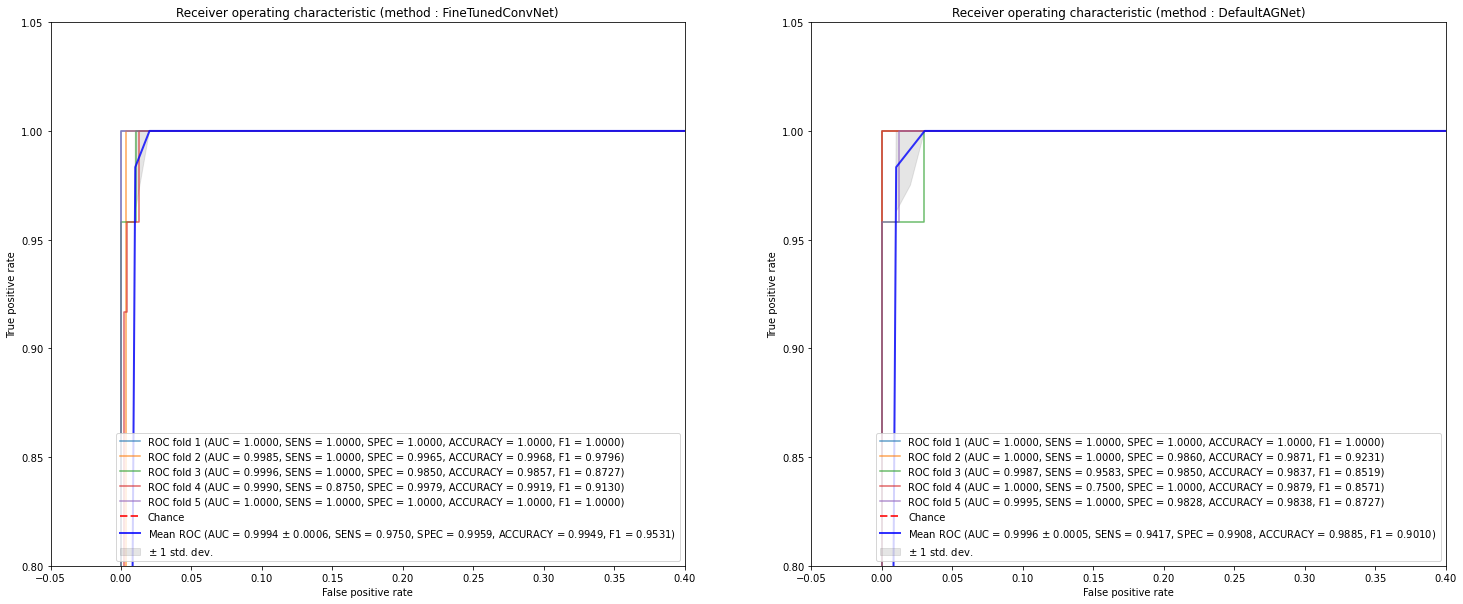

In [85]:
fig, axes = plt.subplots(1,2, figsize=(25,10))

ax1, ax2 = axes

mean_fpr_baseline, mean_tpr_baseline = draw_rocs_cvs(method="FineTunedConvNet", n_folds=5, ax=ax1)
mean_fpr_agnet, mean_tpr_agnet = draw_rocs_cvs(method="DefaultAGNet", n_folds=5, ax=ax2)

plt.savefig("ROC_and_CV_results.png", dpi=300)
plt.show()

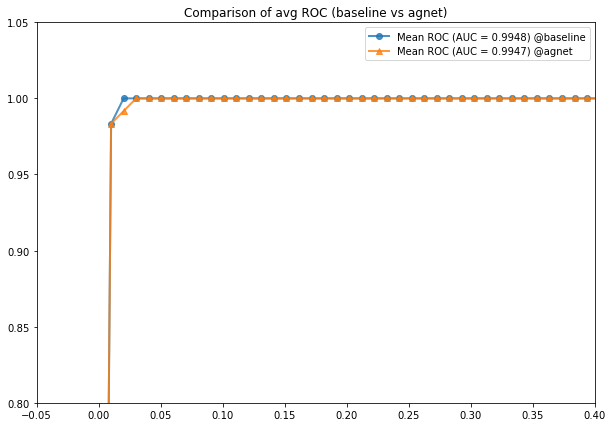

In [86]:
plt.figure(figsize=(10,7))
plt.plot(mean_fpr_baseline, mean_tpr_baseline, marker="o",
         label=r'Mean ROC (AUC = {:.4f}) @baseline'.format(auc(mean_fpr_baseline, mean_tpr_baseline)),
         lw=2, alpha=.8)
plt.plot(mean_fpr_agnet, mean_tpr_agnet, marker="^",
         label=r'Mean ROC (AUC = {:.4f}) @agnet'.format(auc(mean_fpr_agnet, mean_tpr_agnet)),
         lw=2, alpha=.8)

plt.xlim(-0.05, 0.4)
plt.ylim(0.8, 1.05)
plt.title("Comparison of avg ROC (baseline vs agnet)")
plt.legend()
plt.savefig("ROC_comparison.png", dpi=300)
plt.show()